### 1. 구글 드라이브 마운트

In [ ]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. 데이터 불러오기

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

f_lists = '/content/drive/MyDrive/Dataset_공정운영 최적화 AI 데이터셋/dataset'

In [ ]:
import pandas as pd
error_list = pd.read_csv('/content/drive/MyDrive/Dataset_공정운영 최적화 AI 데이터셋/dataset/kemp-process-rate.csv')

In [ ]:
file_list = os.listdir(f_lists)
data_list = [file for file in file_list if file.startswith('kemp-abh-')]

In [ ]:
def csv_read_(data_dir, data_list):
    tmp = pd.read_csv(os.path.join(data_dir, data_list), sep=',', encoding='UTF8')
    y, m, d =map(int, data_list.split('-')[-1].split('.')[:-1])
    time = tmp['Time']
    tmp['DTime'] ='-'.join(data_list.split('-')[-1].split('.')[:-1])
    ctime = time.apply(lambda _ : _.replace(u'오후', 'PM').replace(u'오전', 'AM'))
    n_time = ctime.apply(lambda _ : datetime.datetime.strptime(_, "%p %I:%M:%S"))
    newtime = n_time.apply(lambda _ : _.replace(year=y, month=m, day=d))
    tmp['Time'] = newtime
    return tmp

In [ ]:
len(data_list)

33

In [ ]:
# Combine files with pH, Temp, LoT etc into a single dataframe.
dd = csv_read_(f_lists, data_list[0])
for i in range(1, len(data_list)):
    dd = pd.merge(dd, csv_read_(f_lists, data_list[i]), how='outer')
dd.head(3)

,Index,LoT,Time,pH,Temp,DTime
0,1,1,2021-09-08 09:01:42,1.10,47.59,2021-09-08
1,2,1,2021-09-08 09:01:47,1.12,48.38,2021-09-08
2,3,1,2021-09-08 09:01:52,1.15,48.55,2021-09-08


In [ ]:
# Drop index.
dd = dd.drop('Index', axis=1)
dd.head(3)

,LoT,Time,pH,Temp,DTime
0,1,2021-09-08 09:01:42,1.10,47.59,2021-09-08
1,1,2021-09-08 09:01:47,1.12,48.38,2021-09-08
2,1,2021-09-08 09:01:52,1.15,48.55,2021-09-08


In [ ]:
# Set Time column as an index.
dd = dd.set_index('Time')
dd.head(3)

,LoT,pH,Temp,DTime
Time,,,,
2021-09-08 09:01:42,1,1.10,47.59,2021-09-08
2021-09-08 09:01:47,1,1.12,48.38,2021-09-08
2021-09-08 09:01:52,1,1.15,48.55,2021-09-08


In [ ]:
# Copy dataframe
dedicated_data = dd.copy()
dedicated_data.head()

,LoT,pH,Temp,DTime
Time,,,,
2021-09-08 09:01:42,1,1.10,47.59,2021-09-08
2021-09-08 09:01:47,1,1.12,48.38,2021-09-08
2021-09-08 09:01:52,1,1.15,48.55,2021-09-08
2021-09-08 09:01:57,1,1.25,48.59,2021-09-08
2021-09-08 09:02:02,1,1.34,48.89,2021-09-08


In [ ]:
# Reset index
dedicated_data.reset_index(inplace=True)
dedicated_data.head(3)

,Time,LoT,pH,Temp,DTime
0,2021-09-08 09:01:42,1,1.10,47.59,2021-09-08
1,2021-09-08 09:01:47,1,1.12,48.38,2021-09-08
2,2021-09-08 09:01:52,1,1.15,48.55,2021-09-08


In [ ]:
# Add pH and Temp's mean value columns
data = dedicated_data.groupby(['LoT', 'DTime']).agg({'pH' : 'mean', 'Temp' : 'mean'})
data.reset_index(inplace=True)
data.columns = ['LoT', 'Date', 'pH_mean','Temp_mean']
data.head(3)

,LoT,Date,pH_mean,Temp_mean
0,1,2021-09-06,1.957246,49.950435
1,1,2021-09-07,2.061014,49.545507
2,1,2021-09-08,2.150435,49.242319


In [ ]:
error_list.head()

,Date,LoT,Process Rate
0,2021-09-06,1,96.38
1,2021-09-06,2,97.40
2,2021-09-06,3,95.40
3,2021-09-06,4,96.35
4,2021-09-06,5,94.77


In [ ]:
# Combine with error_list to create a new dataframe.
df = pd.merge(data, error_list, on=['LoT', 'Date'], how='left')
df.head()

,LoT,Date,pH_mean,Temp_mean,Process Rate
0,1,2021-09-06,1.957246,49.950435,96.38
1,1,2021-09-07,2.061014,49.545507,97.20
2,1,2021-09-08,2.150435,49.242319,83.24
3,1,2021-09-09,2.059130,49.243188,82.12
4,1,2021-09-10,1.966957,48.417391,82.82


### 3. 데이터 확인 및 전처리



In [ ]:
# View data information.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 0 to 725
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LoT           726 non-null    int64  
 1   Date          726 non-null    object 
 2   pH_mean       726 non-null    float64
 3   Temp_mean     726 non-null    float64
 4   Process Rate  726 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 34.0+ KB


In [ ]:
# View data summary.
df.describe()

,LoT,pH_mean,Temp_mean,Process Rate
count,726.000000,726.000000,726.000000,726.000000
mean,11.500000,2.006488,49.876127,96.064229
std,6.348663,0.064178,0.268013,3.212802
min,1.000000,1.747536,48.417391,80.780000
25%,6.000000,1.964348,49.808623,96.172500
50%,11.500000,2.004565,49.933043,96.635000
75%,17.000000,2.047971,50.034891,97.257500
max,22.000000,2.259710,50.330435,98.450000


array([[<Axes: title={'center': 'LoT'}>,
        <Axes: title={'center': 'pH_mean'}>],
       [<Axes: title={'center': 'Temp_mean'}>,
        <Axes: title={'center': 'Process Rate'}>]], dtype=object)

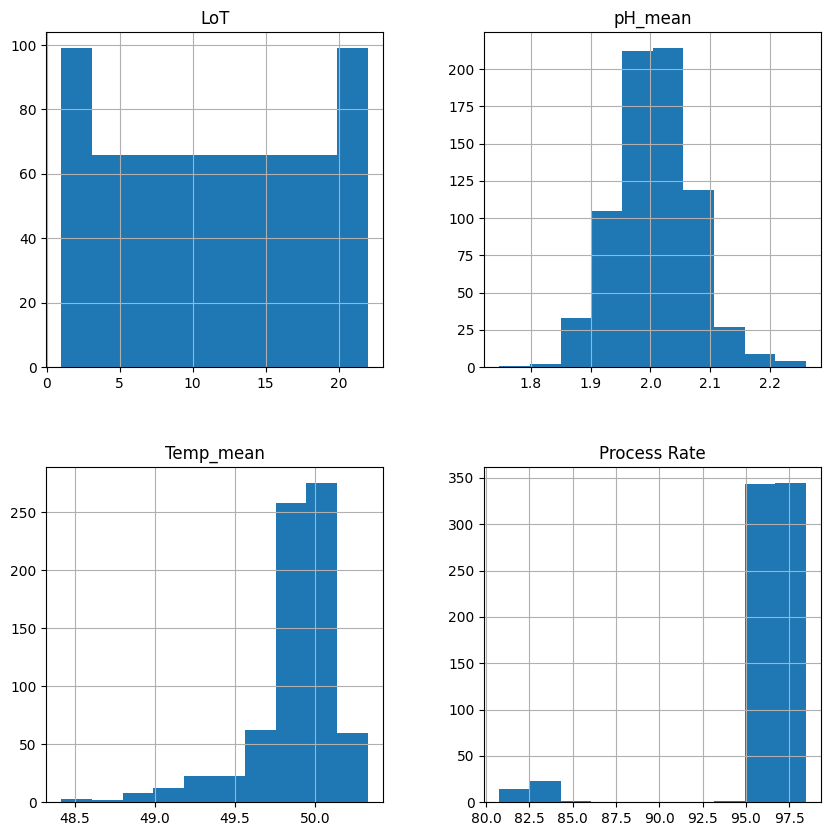

In [ ]:
# View data distribution.
df.hist(figsize=(10,10))

array([[<Axes: title={'center': 'Time'}>,
        <Axes: title={'center': 'LoT'}>],
       [<Axes: title={'center': 'pH'}>, <Axes: title={'center': 'Temp'}>]],
      dtype=object)

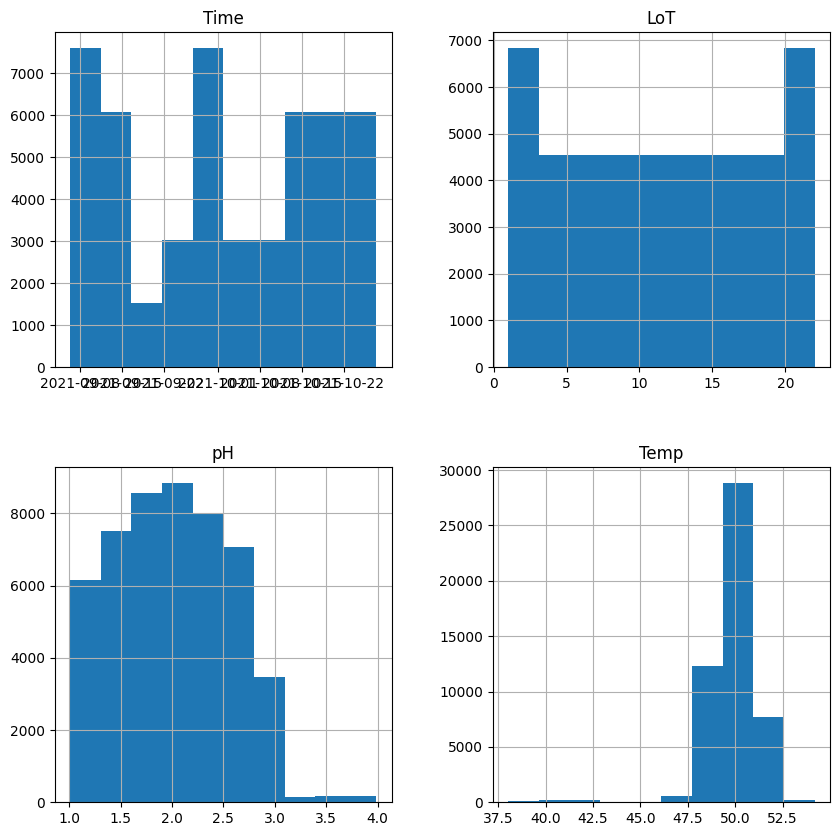

In [ ]:
# Compare before and after averaging.
dedicated_data.hist(figsize=(10,10))

In [ ]:
# Calculate data correlations.
correlation = df.corr()
correlation

<ipython-input-161-8a656be0ac3e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


,LoT,pH_mean,Temp_mean,Process Rate
LoT,1.000000,-0.016713,0.058073,0.295509
pH_mean,-0.016713,1.000000,-0.131197,-0.138536
Temp_mean,0.058073,-0.131197,1.000000,0.716200
Process Rate,0.295509,-0.138536,0.716200,1.000000


<Axes: >

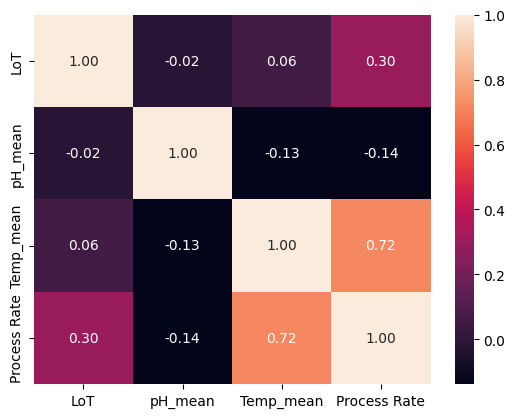

In [ ]:
# Visualize data correlations.
sns.heatmap(correlation, annot=True, fmt='.2f')

### Pivot Table

In [ ]:
# Create a new dataframe to make some pivot tables.
d_lists = dedicated_data['DTime'].unique()
lot_lists = dedicated_data['LoT'].unique()
ot_process_lists = error_list['LoT'].unique()
d_process_lists = error_list['Date'].unique()

new_df = pd.DataFrame(columns=['pH','Temp', 'LoT', 'Process'])

for d in d_lists:
    for lot in lot_lists:
        tmp = dedicated_data[(dedicated_data['DTime']==d)&(dedicated_data['LoT']==lot)]
        tmp = tmp[['pH', 'Temp', 'LoT']]
        process_val = error_list[(error_list['Date']==d)&((error_list['LoT']==lot))]['Process Rate'].values
        trr = np.full((tmp['pH'].shape), process_val)
        tmp['Process'] = trr
        new_df = new_df.append(tmp)
new_df=new_df.apply(pd.to_numeric)
new_df = new_df[['LoT', 'pH', 'Temp', 'Process']]

In [ ]:
new_df.head()

,LoT,pH,Temp,Process
2021-09-08 09:01:42,1,1.10,47.59,83.24
2021-09-08 09:01:47,1,1.12,48.38,83.24
2021-09-08 09:01:52,1,1.15,48.55,83.24
2021-09-08 09:01:57,1,1.25,48.59,83.24
2021-09-08 09:02:02,1,1.34,48.89,83.24


In [ ]:
new_df.reset_index(inplace=True)

In [ ]:
# View the average process rate per LoT.
new_df.pivot_table(index = ['LoT'], values = ['Process'], aggfunc = np.mean)

,Process
LoT,
1,90.048182
2,90.355152
3,95.439697
4,96.849394
5,96.785758
6,96.338788
7,96.877576
8,96.931515
9,96.837273


In [ ]:
pH_q1 = new_df['pH'].quantile(0.25)
pH_q2 = new_df['pH'].quantile(0.5)
Temp_q1 = new_df['Temp'].quantile(0.25)
Temp_q2 = new_df['Temp'].quantile(0.5)
Process_q1 = new_df['Process'].quantile(0.25)
Process_q2 = new_df['Process'].quantile(0.5)

# Create categorical columns with quartiles(pH_cate, Temp_cate, Process_cate).
new_df['pH_cate'] = np.where(new_df['pH'] <= pH_q1, '0.25%(pH)', np.where(new_df['pH'] <= pH_q2, '0.5%(pH)', '0.75%(pH)'))
new_df['Temp_cate'] = np.where(new_df['Temp'] <= Temp_q1, '0.25%(Temp)', np.where(new_df['Temp'] <= Temp_q2, '0.5%(Temp)', '0.75%(Temp)'))
new_df['Process_cate'] = np.where(new_df['Process'] <= Process_q1, '0.25%(Process)', np.where(new_df['Process'] <= Process_q2, '0.5%(Process)', '0.75%(Process)'))
new_df

,index,LoT,pH,Temp,Process,pH_cate,Temp_cate,Process_cate
0,2021-09-08 09:01:42,1,1.10,47.59,83.24,0.25%(pH),0.25%(Temp),0.25%(Process)
1,2021-09-08 09:01:47,1,1.12,48.38,83.24,0.25%(pH),0.25%(Temp),0.25%(Process)
2,2021-09-08 09:01:52,1,1.15,48.55,83.24,0.25%(pH),0.25%(Temp),0.25%(Process)
3,2021-09-08 09:01:57,1,1.25,48.59,83.24,0.25%(pH),0.25%(Temp),0.25%(Process)
4,2021-09-08 09:02:02,1,1.34,48.89,83.24,0.25%(pH),0.25%(Temp),0.25%(Process)
...,...,...,...,...,...,...,...,...
50089,2021-10-19 11:14:41,22,2.82,51.55,97.72,0.75%(pH),0.75%(Temp),0.75%(Process)
50090,2021-10-19 11:14:46,22,2.83,51.55,97.72,0.75%(pH),0.75%(Temp),0.75%(Process)
50091,2021-10-19 11:14:51,22,2.88,51.78,97.72,0.75%(pH),0.75%(Temp),0.75%(Process)
50092,2021-10-19 11:14:56,22,2.91,51.85,97.72,0.75%(pH),0.75%(Temp),0.75%(Process)


In [ ]:
# View the count of process rate's quartiles per LoT.
new_df[['LoT', 'Process', 'Process_cate']].pivot_table(index = ['LoT'], columns = ['Process_cate'], aggfunc = 'count')

Process                             
Process_cate 0.25%(Process) 0.5%(Process) 0.75%(Process)
LoT                                                     
1                      1173           759            345
2                      1380           345            552
3                       828           276           1173
4                       345           690           1242
5                       483           345           1449
6                       552           690           1035
7                       276           897           1104
8                       207           690           1380
9                       621           345           1311
10                       69           897           1311
11                      483           690           1104
12                      759           621            897
13                      552           552           1173
14                      690           483           1104
15                      552           483           1242
16                      483           414           1380
17                      483           621           1173
18                      414           552           1311
19                      414           828           1035
20                      414           621           1242
21                      483           414           1380
22                      897           276           1104

**The results**:
LoT 5 had the highest number of high Process Rate values (1,449) and LoT 2 also had the highest number of LoTs with the lowest Process Rate.

In [ ]:
# Extract only the date part and assign it to a new column.
new_df['date'] = new_df['index'].dt.date
new_df.head()

,index,LoT,pH,Temp,Process,pH_cate,Temp_cate,Process_cate,date
0,2021-09-08 09:01:42,1,1.10,47.59,83.24,0.25%(pH),0.25%(Temp),0.25%(Process),2021-09-08
1,2021-09-08 09:01:47,1,1.12,48.38,83.24,0.25%(pH),0.25%(Temp),0.25%(Process),2021-09-08
2,2021-09-08 09:01:52,1,1.15,48.55,83.24,0.25%(pH),0.25%(Temp),0.25%(Process),2021-09-08
3,2021-09-08 09:01:57,1,1.25,48.59,83.24,0.25%(pH),0.25%(Temp),0.25%(Process),2021-09-08
4,2021-09-08 09:02:02,1,1.34,48.89,83.24,0.25%(pH),0.25%(Temp),0.25%(Process),2021-09-08


In [ ]:
# View the count of process rate's quartiles per Day.
new_df[['date', 'Process', 'Process_cate']].pivot_table(index = ['date'], columns = ['Process_cate'], aggfunc = 'count')

Process                             
Process_cate 0.25%(Process) 0.5%(Process) 0.75%(Process)
date                                                    
2021-09-06              690           414            414
2021-09-07               69           345           1104
2021-09-08              759           414            345
2021-09-09              621           276            621
2021-09-10              621           552            345
2021-09-13              828           414            276
2021-09-14              552           552            414
2021-09-15              345           690            483
2021-09-16              483           690            345
2021-09-17              621           552            345
2021-09-23              621           621            276
2021-09-24              621           552            345
2021-09-27              690           414            414
2021-09-28              759           207            552
2021-09-29              621           483            414
2021-09-30              621           483            414
2021-10-01               69           276           1173
2021-10-05              345           138           1035
2021-10-06               69            69           1380
2021-10-07              345           207            966
2021-10-08              138           207           1173
2021-10-12               69           414           1035
2021-10-13              276           414            828
2021-10-14              207           207           1104
2021-10-15               69           483            966
2021-10-18              207           345            966
2021-10-19              276           345            897
2021-10-20              138           138           1242
2021-10-21              138           414            966
2021-10-22              207           276           1035
2021-10-25              138           345           1035
2021-10-26              138           345           1035
2021-10-27              207           207           1104

**The Results**: '2021-10-06' has the highest Process Rate value, while '2021-09-13' has the lowest.

### 데이터 스케일링

In [ ]:
# Standard 스케일링(머신 러닝 알고리즘에서 잘 작동하며, 이상치에 영향을 적게 받아 일반적으로 많이 사용)
from sklearn.preprocessing import StandardScaler

# pH, Temp 열에 대해 스케일링 진행
selected_features = ['pH', 'Temp']
X = dedicated_data[selected_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 스케일링된 데이터를 DataFrame으로 변환
X_scaled_df = pd.DataFrame(X_scaled, columns=['pH_scaled', 'Temp_scaled'])
X_scaled_df.head()

,pH_scaled,Temp_scaled
0,-1.675833,-2.418687
1,-1.638193,-1.615959
2,-1.581732,-1.443220
3,-1.393530,-1.402575
4,-1.224149,-1.097742


In [ ]:
dedicated_data.reset_index(inplace=True)

In [ ]:
dedicated_data[['pH_scaled', 'Temp_scaled']] = X_scaled_df[['pH_scaled', 'Temp_scaled']]
dedicated_data.head(3)

,index,Time,LoT,pH,Temp,DTime,pH_scaled,Temp_scaled
0,0,2021-09-08 09:01:42,1,1.10,47.59,2021-09-08,-1.675833,-2.418687
1,1,2021-09-08 09:01:47,1,1.12,48.38,2021-09-08,-1.638193,-1.615959
2,2,2021-09-08 09:01:52,1,1.15,48.55,2021-09-08,-1.581732,-1.443220


In [ ]:
dedicated_data.describe()

,index,LoT,pH,Temp,pH_scaled,Temp_scaled
count,49566.000000,49566.000000,49566.000000,49566.000000,4.956600e+04,4.956600e+04
mean,25056.115018,11.509906,1.990445,49.970335,-6.724682e-16,-6.233269e-15
std,14448.858949,6.309785,0.531350,0.984153,1.000010e+00,1.000010e+00
min,0.000000,1.000000,1.010000,45.250000,-1.845215e+00,-4.796390e+00
25%,12562.250000,6.000000,1.560000,49.300000,-8.101049e-01,-6.811356e-01
50%,25038.500000,12.000000,1.990000,49.980000,-8.372371e-04,9.820613e-03
75%,37560.750000,17.000000,2.420000,50.640000,8.084304e-01,6.804546e-01
max,50092.000000,22.000000,2.990000,54.190000,1.881181e+00,4.287653e+00


In [ ]:
d_lists = dedicated_data['DTime'].unique()
lot_lists = dedicated_data['LoT'].unique()
ot_process_lists = error_list['LoT'].unique()
d_process_lists = error_list['Date'].unique()

X_data = pd.DataFrame(columns=['pH_scaled','Temp_scaled', 'LoT', 'Process'])

for d in d_lists:
    for lot in lot_lists:
        tmp = dedicated_data[(dedicated_data['DTime']==d)&(dedicated_data['LoT']==lot)]
        tmp = tmp[['pH_scaled', 'Temp_scaled', 'LoT']]
        process_val = error_list[(error_list['Date']==d)&((error_list['LoT']==lot))]['Process Rate'].values
        trr = np.full((tmp['pH_scaled'].shape), process_val)
        tmp['Process'] = trr
        X_data = X_data.append(tmp)
X_data=X_data.apply(pd.to_numeric)
X_data = X_data[['LoT', 'pH_scaled', 'Temp_scaled', 'Process']]

In [ ]:
X_data.head(3)

,LoT,pH_scaled,Temp_scaled,Process
0,1,-1.643104,-1.699333,83.24
1,1,-1.606852,-1.112107,83.24
2,1,-1.552474,-0.985742,83.24


In [ ]:
X_data.describe()

,LoT,pH_scaled,Temp_scaled,Process,Process Rate_kbin
count,49566.000000,4.956600e+04,4.956600e+04,49566.000000,49566.00000
mean,11.509906,-6.724682e-16,-6.233269e-15,96.120904,0.95162
std,6.309785,1.000010e+00,1.000010e+00,3.098829,0.21457
min,1.000000,-1.845215e+00,-4.796390e+00,80.780000,0.00000
25%,6.000000,-8.101049e-01,-6.811356e-01,96.180000,1.00000
50%,12.000000,-8.372371e-04,9.820613e-03,96.640000,1.00000
75%,17.000000,8.084304e-01,6.804546e-01,97.260000,1.00000
max,22.000000,1.881181e+00,4.287653e+00,98.450000,1.00000


array([[<Axes: title={'center': 'LoT'}>,
        <Axes: title={'center': 'pH_scaled'}>],
       [<Axes: title={'center': 'Temp_scaled'}>,
        <Axes: title={'center': 'Process'}>],
       [<Axes: title={'center': 'Process Rate_kbin'}>, <Axes: >]],
      dtype=object)

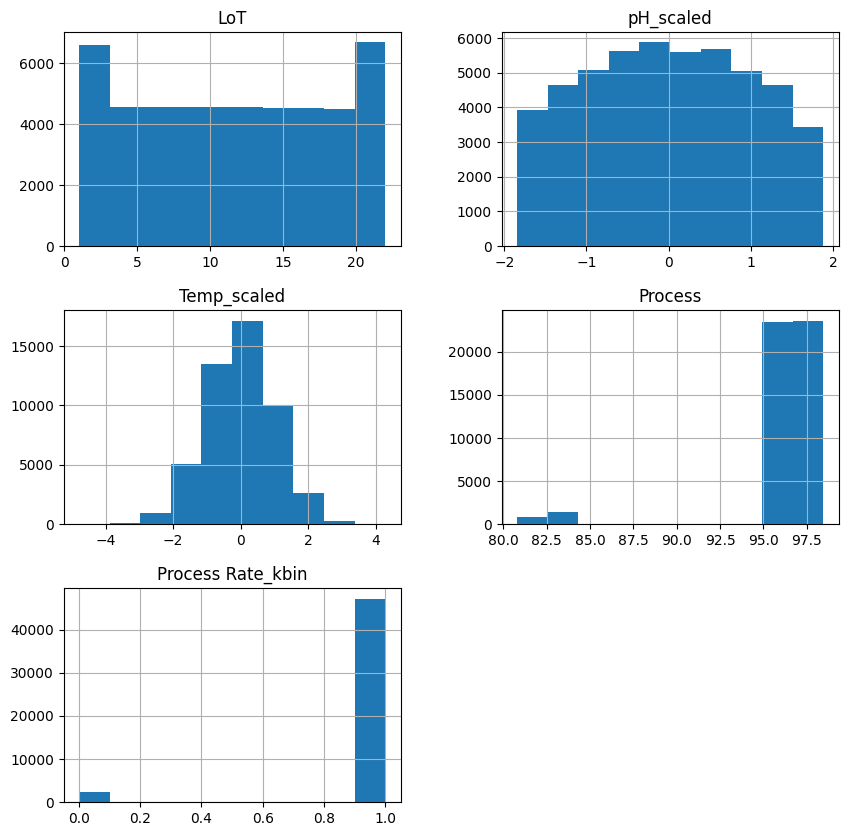

In [ ]:
X_data.hist(figsize=(10,10))

### K-means binning

In [ ]:
# Categorizing the 'Process Rate' column to differentiate between success and poor.
from sklearn.preprocessing import KBinsDiscretizer

col_name = 'Process Rate'
trans_col_name = 'Process Rate_kbin'

kbin_discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')
new_df[trans_col_name]= kbin_discretizer.fit_transform(new_df[[col_name]])

In [ ]:
new_df.head(3)

,LoT,Date,pH_mean,pH_var,Temp_mean,Temp_var,Process Rate,Process Rate_kbin
0,1,2021-09-06,1.957246,0.242773,49.950435,0.989842,96.38,1.0
1,1,2021-09-07,2.061014,0.367636,49.545507,4.207581,97.20,1.0
2,1,2021-09-08,2.150435,0.327540,49.242319,7.302824,83.24,0.0


<Axes: xlabel='Process Rate_kbin', ylabel='count'>

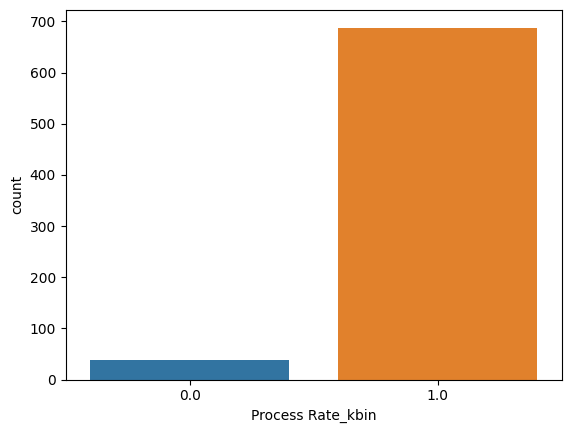

In [ ]:
import seaborn as sns
sns.countplot(data = new_df, x='Process Rate_kbin')

### SMOTE를 통한 오버샘플링

In [ ]:
X_data.describe()

,LoT,pH_scaled,Temp_scaled,Process,Process Rate_kbin
count,49566.000000,4.956600e+04,4.956600e+04,49566.000000,49566.00000
mean,11.509906,-6.724682e-16,-6.233269e-15,96.120904,0.95162
std,6.309785,1.000010e+00,1.000010e+00,3.098829,0.21457
min,1.000000,-1.845215e+00,-4.796390e+00,80.780000,0.00000
25%,6.000000,-8.101049e-01,-6.811356e-01,96.180000,1.00000
50%,12.000000,-8.372371e-04,9.820613e-03,96.640000,1.00000
75%,17.000000,8.084304e-01,6.804546e-01,97.260000,1.00000
max,22.000000,1.881181e+00,4.287653e+00,98.450000,1.00000


In [ ]:
# imbalanced-learn 패키지
from imblearn.over_sampling import SMOTE
from collections import Counter

# 데이터 분할
X = new_df[['pH_mean', 'Temp_mean']]
y = new_df['Process Rate_kbin']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE 적용 전 클래스 분포 확인
print("SMOTE 적용 전 클래스 분포:", Counter(y_train2))
print(new_df['pH_mean'].mean(), new_df['Temp_mean'].mean())

# 검증 데이터나 테스트 데이터가 아닌 학습데이터에서만 오버샘플링 사용할 것
smote = SMOTE(random_state=42) # 11
X_train_over, y_train_over = smote.fit_resample(X_train2, y_train2)

# SMOTE 적용 후 클래스 분포 확인
print("SMOTE 적용 후 클래스 분포:", Counter(y_train_over))
print(new_df['pH_mean'].mean(), new_df['Temp_mean'].mean())

SMOTE 적용 전 클래스 분포: Counter({1.0: 550, 0.0: 30})
2.006488002555196 49.87612688146286
SMOTE 적용 후 클래스 분포: Counter({1.0: 550, 0.0: 550})
2.006488002555196 49.87612688146286


In [ ]:
# y_train_over[y_train_over == 1.0].count()

37970

In [ ]:
# y_train_over[y_train_over == 0.0].count()

37970

In [ ]:
new_df.head()

,LoT,Date,pH,Temp,Process Rate
0,1,2021-09-06,1.957246,49.950435,96.38
1,1,2021-09-07,2.061014,49.545507,97.20
2,1,2021-09-08,2.150435,49.242319,83.24
3,1,2021-09-09,2.059130,49.243188,82.12
4,1,2021-09-10,1.966957,48.417391,82.82


In [ ]:
# 오버샘플링 X
# 데이터 분할
X = new_df[['pH_mean','Temp_mean']]
y = new_df['Process Rate_kbin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
'''X = new_df[['pH', 'Temp']]
y = new_df['Process Rate_kbin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)'''

"X = new_df[['pH', 'Temp']]\ny = new_df['Process Rate_kbin']\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)"

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# n_neighbors 값 리스트
n_neighbors_list = [2, 3, 4, 5, 6, 7, 10]

for n in n_neighbors_list:
    # KNN 모델 생성
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)  # 모델 학습

    # 테스트 데이터를 사용하여 예측
    predictions = knn.predict(X_test)

    # 정확도 계산 및 출력
    accuracy = accuracy_score(y_test, predictions)
    print(f"n_neighbors가 {n}인 경우 정확도: {accuracy}")

n_neighbors가 2인 경우 정확도: 0.9794520547945206
n_neighbors가 3인 경우 정확도: 0.9726027397260274
n_neighbors가 4인 경우 정확도: 0.9863013698630136
n_neighbors가 5인 경우 정확도: 0.9794520547945206
n_neighbors가 6인 경우 정확도: 0.9794520547945206
n_neighbors가 7인 경우 정확도: 0.9794520547945206
n_neighbors가 10인 경우 정확도: 0.9794520547945206


In [ ]:
## n_neighbors가 7인 경우 정확도가 0.94769937119473로 가장 높은 것 확인

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score

def print_reg_metrics(y_test, y_pred):
   print(f'MSE:{mean_squared_error(y_test, y_pred)}')
   print(f'MAE:{mean_absolute_error(y_test, y_pred)}')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# KNN 모델 생성 및 학습
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

# 테스트 데이터를 사용하여 예측
predictions = knn.predict(X_test)

# 모델 성능 지표 계산
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"정확도(accuracy): {accuracy}")
print(f"정밀도(precision): {precision}")
print(f"재현율(recall): {recall}")
print(f'MAPE:{mean_absolute_percentage_error(y_test, predictions)}')
print(f'R2:{r2_score(y_test, predictions)}')
print(f"F1 Score: {f1:.2f}")
print_reg_metrics(y_test, predictions)

정확도(accuracy): 0.9863013698630136
정밀도(precision): 0.9927536231884058
재현율(recall): 0.9927536231884058
MAPE:30846572790208.883
R2:0.7355072463768116
F1 Score: 0.99
MSE:0.0136986301369863
MAE:0.0136986301369863


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


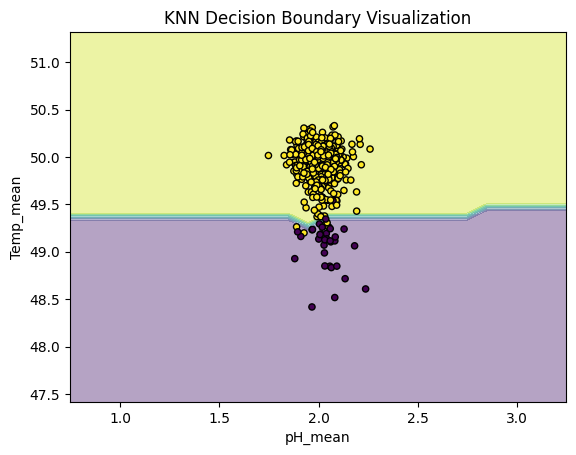

In [ ]:
# 결정 경계 시각화를 위해 pH와 Temp의 범위를 설정합니다.
x_min, x_max = X_train['pH_mean'].min() - 1, X_train['pH_mean'].max() + 1
y_min, y_max = X_train['Temp_mean'].min() - 1, X_train['Temp_mean'].max() + 1

# 결정 경계를 만들기 위해 pH와 Temp에 대한 격자 포인트를 생성합니다.
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# 각 격자 포인트에 대한 예측을 수행합니다.
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 훈련 데이터를 기반으로 결정 경계를 시각화합니다.
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train['pH_mean'], X_train['Temp_mean'], c=y_train, s=20, edgecolor='k')
plt.xlabel('pH_mean')
plt.ylabel('Temp_mean')
plt.title('KNN Decision Boundary Visualization')
plt.show()

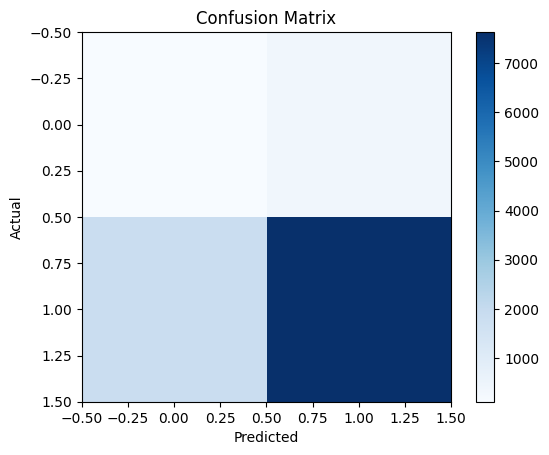

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


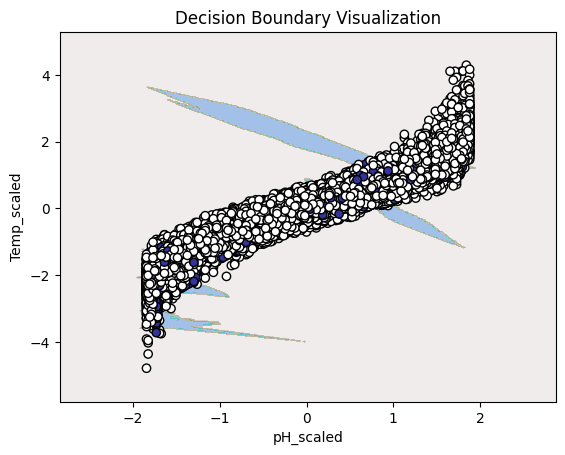

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# KNN 모델 학습
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_over, y_train_over)

# 검증 데이터에 대한 예측
y_pred = knn.predict(X_test)

# Confusion Matrix 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Decision Boundary Visualization(결정 경계 시각화)
def plot_decision_boundary(X, y, model):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4, cmap='terrain')
    plt.scatter(X[:, 0], X[:, 1], c=y,  cmap='terrain', edgecolors='k')
   # plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.xlabel('pH_scaled')
    plt.ylabel('Temp_scaled')
    plt.title('Decision Boundary Visualization')
    plt.show()

X_combined = np.vstack((X_train_over, X_test))
y_combined = np.hstack((y_train_over, y_test))
plot_decision_boundary(X_combined, y_combined, knn)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


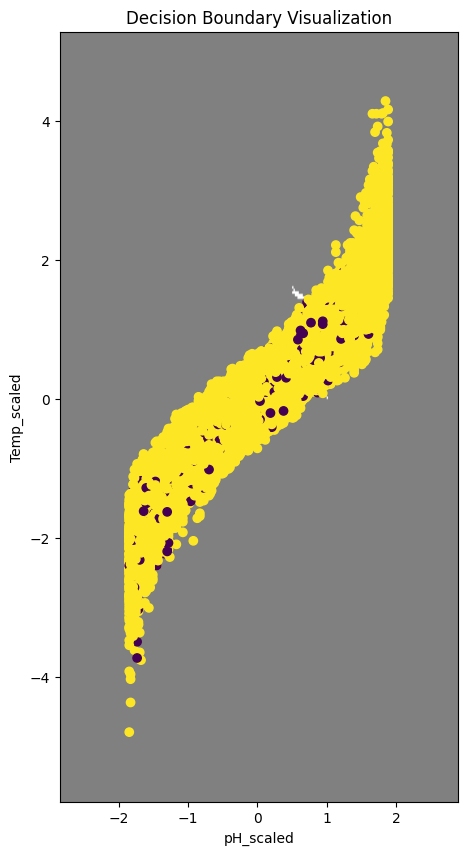

In [ ]:
scale = 300

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

xmax = X_combined[:, 0].max() + 1
xmin = X_combined[:, 0].min() - 1
ymax = X_combined[:, 1].max() + 1
ymin = X_combined[:, 1].min() - 1

xx = np.linspace(xmin, xmax, scale)
yy = np.linspace(ymin, ymax, scale)
data1, data2 = np.meshgrid(xx, yy)
X_grid = np.c_[data1.ravel(), data2.ravel()]
pred = knn.predict(X_grid)

fig = plt.figure(figsize=[12, 10])

# Reshape pred_y to fit the meshgrid
pred = pred.reshape(len(yy), len(xx))  # yy, xx 순서로 reshape

plt.imshow(pred, interpolation=None, origin='lower',
           extent=[xmin, xmax, ymin, ymax], alpha=0.5, cmap='gray_r')

# Draw X_train
plt.scatter(X_combined[:, 0], X_combined[:, 1], c=y_combined)

plt.xlabel('pH_scaled')
plt.ylabel('Temp_scaled')
plt.title('Decision Boundary Visualization')
plt.show()


In [ ]:
from sklearn.model_selection import KFold

# KFold를 통한 교차 검증
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_idx, test_idx in kfold.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # 모델 생성 및 학습
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_fold, y_train_fold)

    # 테스트 데이터로 평가
    accuracy = knn.score(X_test_fold, y_test_fold)
    accuracies.append(accuracy)
    print(f"폴드 정확도: {accuracy}")

# 교차 검증 결과 요약
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"\n평균 정확도: {mean_accuracy}")
print(f"정확도 표준 편차: {std_accuracy}")

폴드 정확도: 0.9430084478628168
폴드 정확도: 0.9435127978817299
폴드 정확도: 0.9460277427490542
폴드 정확도: 0.9435056746532157
폴드 정확도: 0.9440100882723833

평균 정확도: 0.9440129502838399
정확도 표준 편차: 0.0010560211147128478


In [ ]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 2차원 데이터 생성
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, random_state=42)

# KNN 모델 학습
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

# 결정 경계 시각화
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("KNN Classification")
plt.show()


### Linear Regression

In [ ]:
# 결정 경계 시각화 함수
def plot_decision_boundary(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, edgecolors='k')

    # 결정 경계 표시
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                         np.linspace(ylim[0], ylim[1], 100))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.title('Decision Boundary of SVM')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# 결정 경계 시각화 함수 호출
plot_decision_boundary(X, y, svm)


NameError: ignored

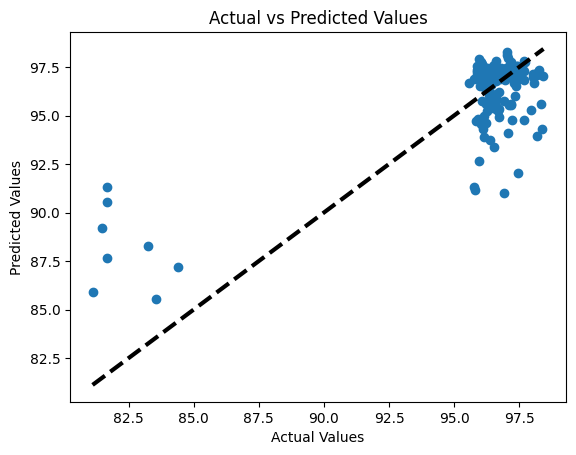

In [ ]:
# 산점도 그리기
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

# 대각선으로 실제 값과 예측 값이 일치하는 직선 그리기
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.show()

### Decision tree regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# 의사 결정 나무 회귀 모델 생성
dt_model = DecisionTreeRegressor(random_state=42, max_depth=3)

# 모델 훈련
dt_model.fit(X_train, y_train)

# 예측
y_pred = dt_model.predict(X_test)

# 평가
def print_reg_metrics(y_test, y_pred):
   mse = mean_squared_error(y_test, y_pred)
   mae = mean_absolute_error(y_test, y_pred)
   mape = mean_absolute_percentage_error(y_test, y_pred)
   r2 = r2_score(y_test, y_pred)

   print(f'MSE: {mse:.2f}')
   print(f'MAE: {mae:.2f}')
   print(f'MAPE: {mape:.2f}%')
   print(f'R2: {r2:.2f}')

# 함수 호출
print_reg_metrics(y_test, y_pred)

MSE: 2.51
MAE: 0.77
MAPE: 0.01%
R2: 0.78


In [ ]:
param_grid = {
    'max_depth': [3, 5, 7, 10, None]  # 적절한 범위 설정
}

# GridSearchCV를 사용하여 최적의 max_depth 탐색
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train, y_train)

# 최적의 max_depth 출력
print("Best Max Depth:", grid_result.best_params_['max_depth'])

Best Max Depth: 3


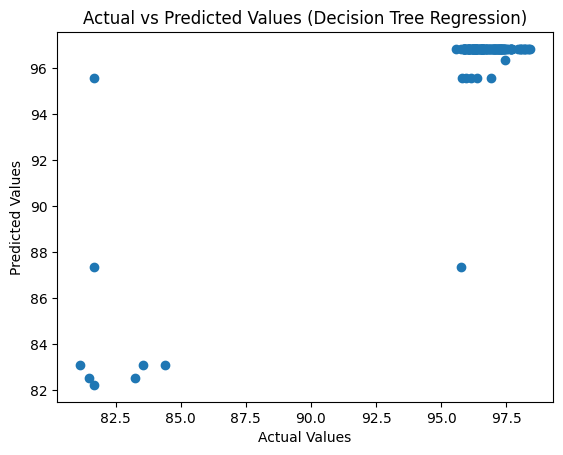

In [ ]:
# 실제값과 예측값 비교하여 시각화
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Decision Tree Regression)')
plt.show()

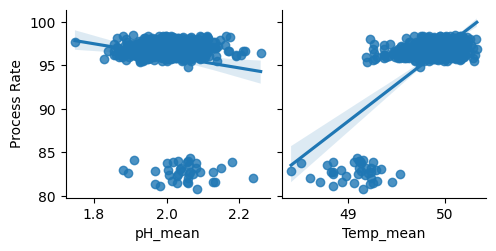

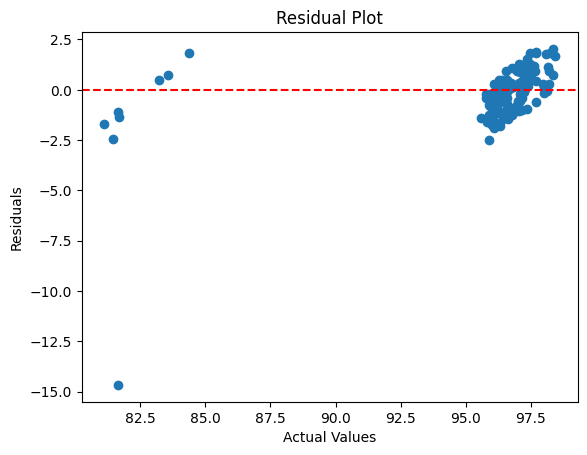

In [ ]:
# 특성별 시각화
sns.pairplot(new_df, x_vars=['pH_mean', 'Temp_mean'], y_vars='Process Rate', kind='reg')
plt.show()

# 잔차 플롯
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.show()

[Text(0.5, 0.875, 'Temp_mean <= 49.26\nsquared_error = 10.058\nsamples = 580\nvalue = 96.082'),
 Text(0.25, 0.625, 'Temp_mean <= 49.184\nsquared_error = 17.501\nsamples = 30\nvalue = 84.202'),
 Text(0.125, 0.375, 'pH_mean <= 2.083\nsquared_error = 0.837\nsamples = 21\nvalue = 82.897'),
 Text(0.0625, 0.125, 'squared_error = 0.566\nsamples = 16\nvalue = 83.105'),
 Text(0.1875, 0.125, 'squared_error = 1.123\nsamples = 5\nvalue = 82.232'),
 Text(0.375, 0.375, 'Temp_mean <= 49.233\nsquared_error = 43.135\nsamples = 9\nvalue = 87.248'),
 Text(0.3125, 0.125, 'squared_error = 44.886\nsamples = 5\nvalue = 91.022'),
 Text(0.4375, 0.125, 'squared_error = 0.883\nsamples = 4\nvalue = 82.53'),
 Text(0.75, 0.625, 'Temp_mean <= 49.358\nsquared_error = 1.534\nsamples = 550\nvalue = 96.73'),
 Text(0.625, 0.375, 'Temp_mean <= 49.283\nsquared_error = 38.862\nsamples = 6\nvalue = 91.848'),
 Text(0.5625, 0.125, 'squared_error = 0.277\nsamples = 3\nvalue = 96.343'),
 Text(0.6875, 0.125, 'squared_error = 37.0

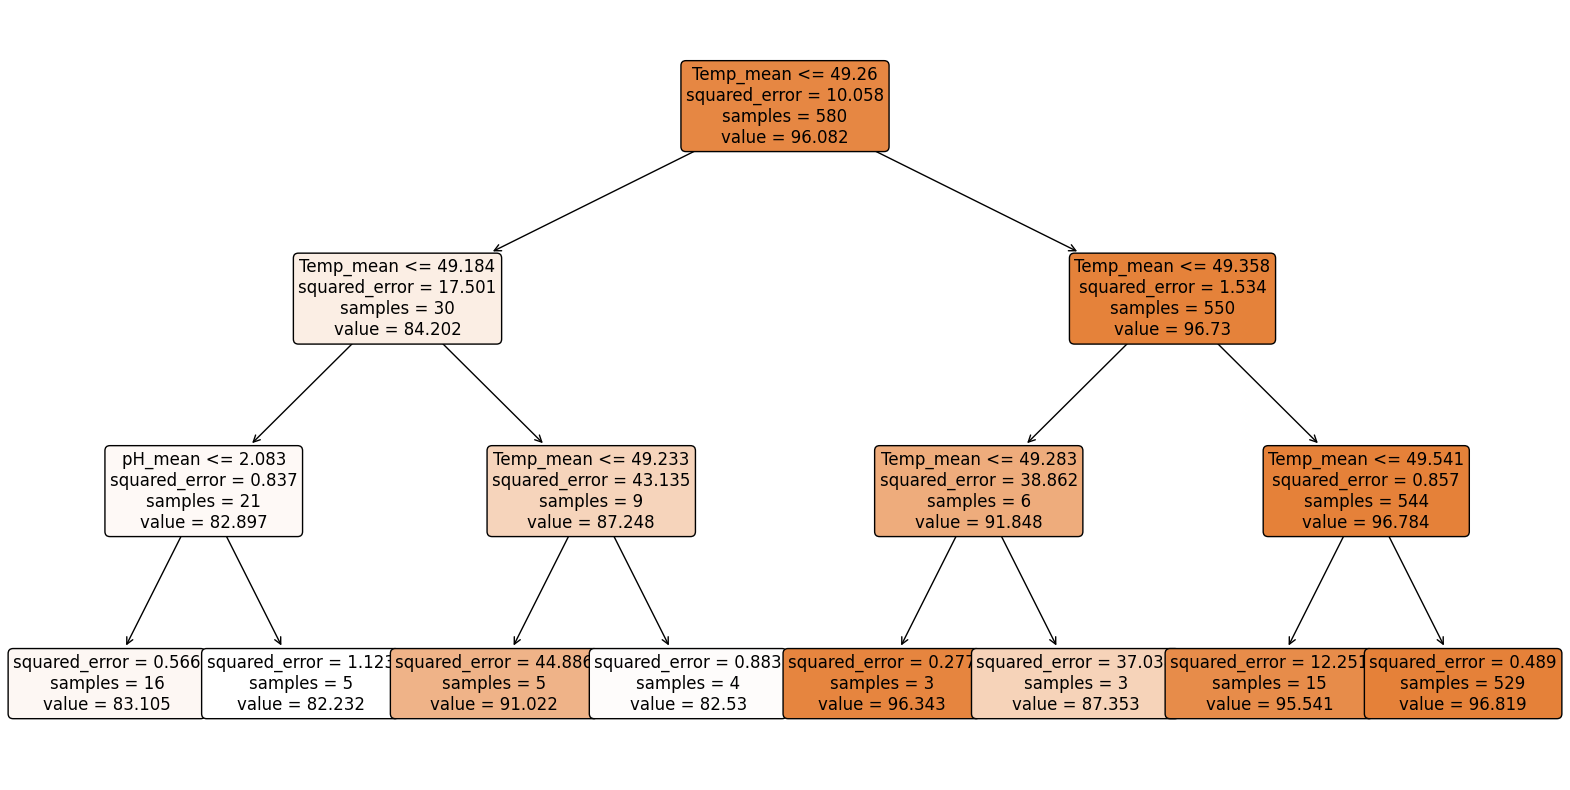

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, rounded=True, fontsize=12)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression 모델 생성 및 학습
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# 테스트 데이터를 사용하여 예측
predictions = logistic_regression.predict(X_test)

# 모델 성능 지표 계산
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"정확도(accuracy): {accuracy}")
print(f"정밀도(precision): {precision}")
print(f"재현율(recall): {recall}")
print(f'MAPE:{mean_absolute_percentage_error(y_test, predictions)}')
print(f'R2:{r2_score(y_test, predictions)}')
print(f"F1 Score: {f1:.2f}")
print_reg_metrics(y_test, predictions)

정확도(accuracy): 0.9726027397260274
정밀도(precision): 0.971830985915493
재현율(recall): 1.0
MAPE:123386291160835.5
R2:0.4710144927536233
F1 Score: 0.99
MSE: 0.03
MAE: 0.03
MAPE: 123386291160835.50%
R2: 0.47


In [ ]:
from sklearn.model_selection import KFold

# KFold를 통한 교차 검증
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_idx, test_idx in kfold.split(X_train_over):
    X_train_fold, X_test_fold = X_train_over.iloc[train_idx], X_train_over.iloc[test_idx]
    y_train_fold, y_test_fold = y_train_over.iloc[train_idx], y_train_over.iloc[test_idx]

    # 모델 생성 및 학습
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train_fold, y_train_fold)

    # 테스트 데이터로 평가
    accuracy = logistic_regression.score(X_test_fold, y_test_fold)
    accuracies.append(accuracy)
    print(f"폴드 정확도: {accuracy}")

# 교차 검증 결과 요약
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"\n평균 정확도: {mean_accuracy}")
print(f"정확도 표준 편차: {std_accuracy}")

폴드 정확도: 0.9772727272727273
폴드 정확도: 0.9818181818181818
폴드 정확도: 0.9772727272727273
폴드 정확도: 0.990909090909091
폴드 정확도: 0.9863636363636363

평균 정확도: 0.9827272727272728
정확도 표준 편차: 0.005300865358950277


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<Axes: >

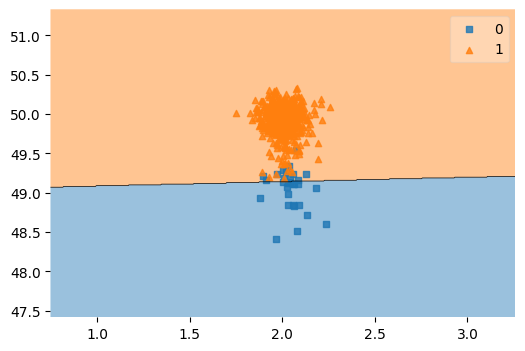

In [ ]:
from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(6,4))
scatter_kwargs = {'s': 20, 'edgecolor': None, 'alpha': 0.8}
plot_decision_regions(X=np.array(X_train), y=np.array(y_train).astype(int), clf=logistic_regression, scatter_kwargs=scatter_kwargs)

### Decision Tree

In [ ]:
'''from sklearn.tree import DecisionTreeClassifier

# 랜덤 시드 설정
random_seed = 42
np.random.seed(random_seed)

# Decision Tree 모델 생성 및 학습
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# 테스트 데이터를 사용하여 예측
predictions = decision_tree.predict(X_test)

# 모델 성능 지표 계산
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"정확도(accuracy): {accuracy}")
print(f"정밀도(precision): {precision}")
print(f"재현율(recall): {recall}")
print(f'MAPE:{mean_absolute_percentage_error(y_test, predictions)}')
print(f'R2:{r2_score(y_test, predictions)}')
print(f"F1 Score: {f1:.2f}")
print_reg_metrics(y_test, predictions)

# 각 특성의 중요도 출력
importance = decision_tree.feature_importances_
print("\n각 특성의 중요도:")
for i, imp in enumerate(importance):
    print(f"특성 {i+1}: {imp}")'''

정확도(accuracy): 0.9109691585986626
정밀도(precision): 0.9512578616352201
재현율(recall): 0.9550620921911177
MAPE:209020244208731.47
R2:-0.8192134649856881
F1 Score: 0.95
MSE:0.08903084140133746
MAE:0.08903084140133746

각 특성의 중요도:
특성 1: 0.43606948604951185
특성 2: 0.5639305139504881


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# 탐색할 max_depth 값의 범위 설정
param_grid = {'max_depth': [None, 3, 5, 7, 10, 20]}

# 랜덤 시드 설정
random_seed = 42
np.random.seed(random_seed)

# Decision Tree 모델 생성
decision_tree = DecisionTreeClassifier(random_state=42)

# GridSearchCV를 사용하여 최적의 max_depth 탐색
grid_search = GridSearchCV(decision_tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# 최적의 max_depth 출력
best_max_depth = grid_search.best_params_['max_depth']
print(f"최적의 max_depth: {best_max_depth}")
11114
# 테스트 데이터로 최적의 모델 평가
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# 모델 성능 지표 계산
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"정확도(accuracy): {accuracy}")
print(f"정밀도(precision): {precision}")
print(f"재현율(recall): {recall}")
print(f'MAPE:{mean_absolute_percentage_error(y_test, predictions)}')
print(f'R2:{r2_score(y_test, predictions)}')
print(f"F1 Score: {f1:.2f}")
print_reg_metrics(y_test, predictions)

최적의 max_depth: 3
정확도(accuracy): 0.9863013698630136
정밀도(precision): 0.9927536231884058
재현율(recall): 0.9927536231884058
MAPE:30846572790208.883
R2:0.7355072463768116
F1 Score: 0.99
MSE: 0.01
MAE: 0.01
MAPE: 30846572790208.88%
R2: 0.74


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 랜덤 시드 설정
random_seed = 42
np.random.seed(random_seed)

# Decision Tree 모델 생성 및 학습
decision_tree = DecisionTreeClassifier(random_state=42, max_depth=3)
decision_tree.fit(X_train, y_train)

# 테스트 데이터를 사용하여 예측
predictions = decision_tree.predict(X_test)

# 모델 성능 지표 계산
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"정확도(accuracy): {accuracy}")
print(f"정밀도(precision): {precision}")
print(f"재현율(recall): {recall}")
print(f'MAPE:{mean_absolute_percentage_error(y_test, predictions)}')
print(f'R2:{r2_score(y_test, predictions)}')
print(f"F1 Score: {f1:.2f}")
print_reg_metrics(y_test, predictions)

# 각 특성의 중요도 출력
importance = decision_tree.feature_importances_
print("\n각 특성의 중요도:")
for i, imp in enumerate(importance):
    print(f"특성 {i+1}: {imp}")

정확도(accuracy): 0.9863013698630136
정밀도(precision): 0.9927536231884058
재현율(recall): 0.9927536231884058
MAPE:30846572790208.883
R2:0.7355072463768116
F1 Score: 0.99
MSE: 0.01
MAE: 0.01
MAPE: 30846572790208.88%
R2: 0.74

각 특성의 중요도:
특성 1: 0.0
특성 2: 1.0


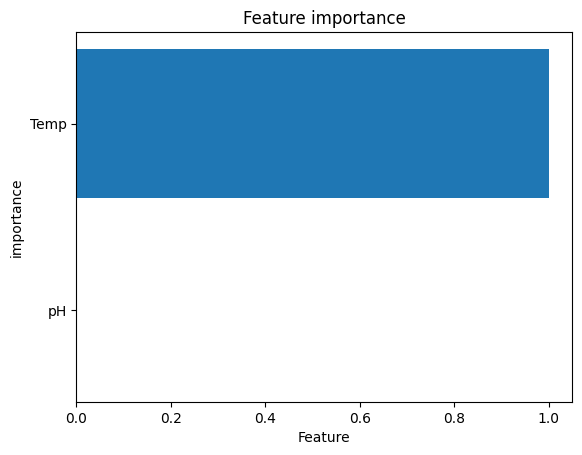

In [ ]:
# 변수 중요도 시각화 (예: Permutation Importance)
features = ['pH', 'Temp']
plt.barh(features, importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('importance')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

# KFold를 통한 교차 검증
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_idx, test_idx in kfold.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # 모델 생성 및 학습
    decision_tree = DecisionTreeClassifier(max_depth=3, random_state=42)  # 최적의 max_depth 사용
    decision_tree.fit(X_train_fold, y_train_fold)

    # 테스트 데이터로 평가
    accuracy = decision_tree.score(X_test_fold, y_test_fold)
    accuracies.append(accuracy)
    print(f"폴드 정확도: {accuracy}")

# 교차 검증 결과 요약
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"\n평균 정확도: {mean_accuracy}")
print(f"정확도 표준 편차: {std_accuracy}")

폴드 정확도: 1.0
폴드 정확도: 0.9913793103448276
폴드 정확도: 0.9913793103448276
폴드 정확도: 0.9482758620689655
폴드 정확도: 0.9655172413793104

평균 정확도: 0.9793103448275863
정확도 표준 편차: 0.01935340027641694


[Text(0.5555555555555556, 0.875, 'Temp_mean <= 49.261\ngini = 0.09\nsamples = 464\nvalue = [22, 442]'),
 Text(0.3333333333333333, 0.625, 'pH_mean <= 1.969\ngini = 0.091\nsamples = 21\nvalue = [20, 1]'),
 Text(0.2222222222222222, 0.375, 'Temp_mean <= 49.221\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.1111111111111111, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.3333333333333333, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.4444444444444444, 0.375, 'gini = 0.0\nsamples = 18\nvalue = [18, 0]'),
 Text(0.7777777777777778, 0.625, 'Temp_mean <= 49.358\ngini = 0.009\nsamples = 443\nvalue = [2, 441]'),
 Text(0.6666666666666666, 0.375, 'Temp_mean <= 49.283\ngini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(0.5555555555555556, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.7777777777777778, 0.125, 'gini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.8888888888888888, 0.375, 'gini = 0.0\nsamples = 438\nvalue = [0, 438]')]

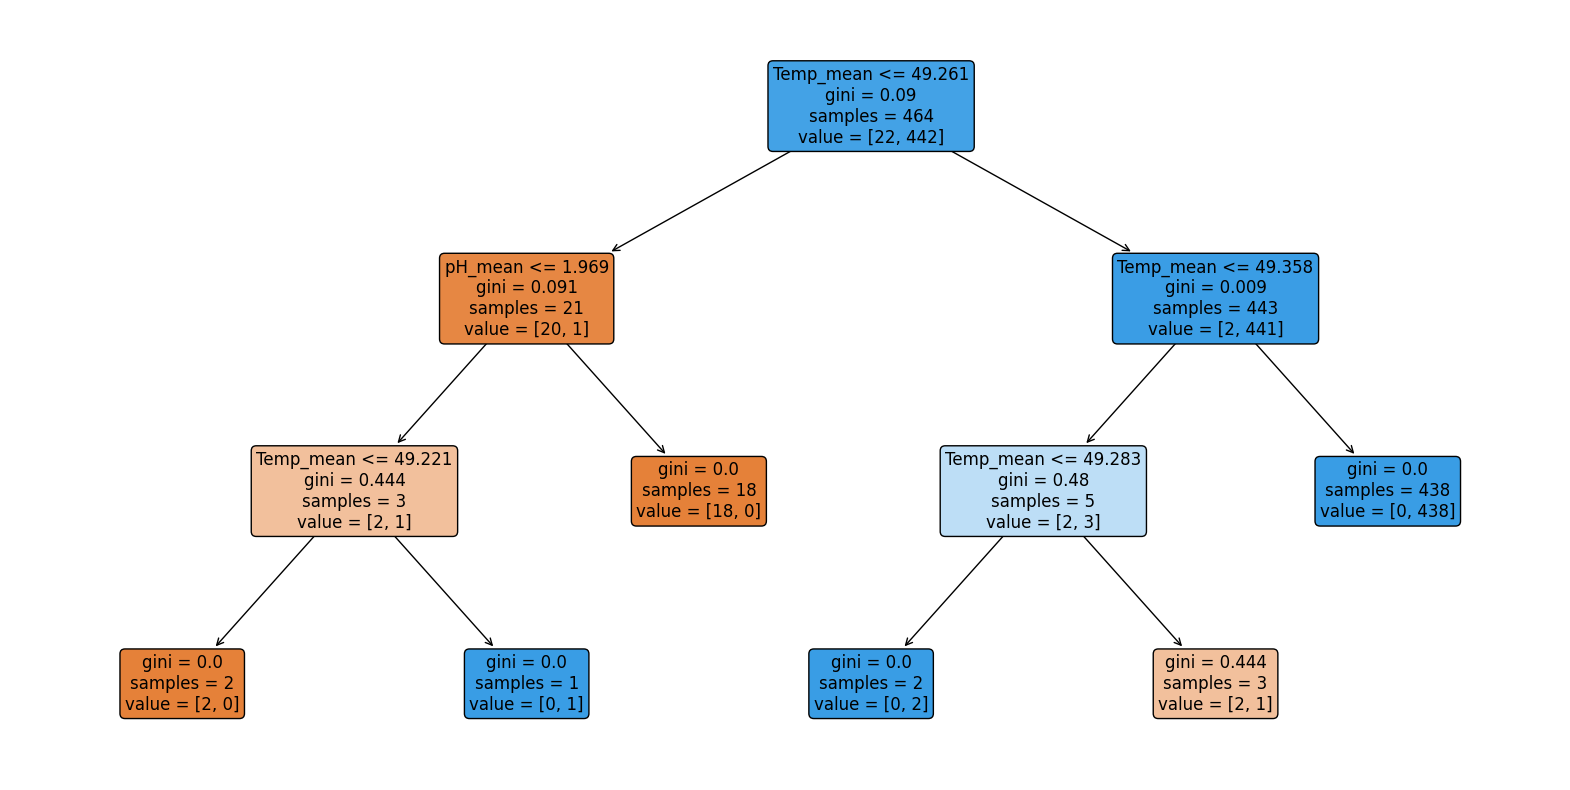

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(decision_tree, feature_names=X_train.columns, filled=True, rounded=True, fontsize=12)

In [ ]:
## 노드 색상이 진할수록 불순도가 낮아(gini 계수가 작아) 분류가 잘 되었음을 의미

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Axes: >

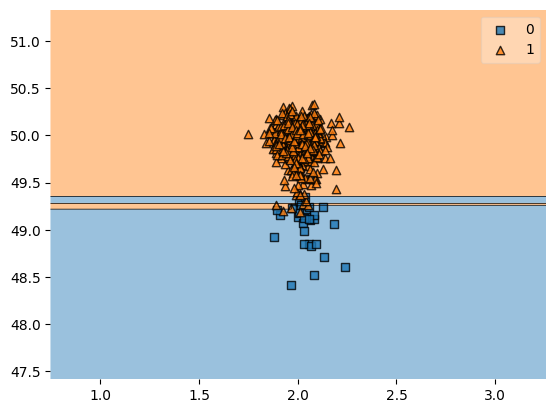

In [ ]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_train.values, np.array(y_train).astype(int), clf=decision_tree, legend=True)

In [ ]:
y_train

19979    1.0
5665     1.0
2989     0.0
11270    1.0
45638    0.0
        ... 
11284    1.0
44732    1.0
38158    1.0
860      1.0
15795    1.0
Name: Process Rate_kbin, Length: 40075, dtype: float64

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# 랜덤 포레스트 회귀 모델 생성
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 모델 훈련
rf_model.fit(X_train_over, y_train_over)

# 예측
y_pred = rf_model.predict(X_test)

# 모델 성능 지표 계산
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"정확도(accuracy): {accuracy}")
print(f"정밀도(precision): {precision}")
print(f"재현율(recall): {recall}")
print(f'MAPE:{mean_absolute_percentage_error(y_test, predictions)}')
print(f'R2:{r2_score(y_test, predictions)}')
print(f"F1 Score: {f1:.2f}")
print_reg_metrics(y_test, predictions)

# 각 특성의 중요도 출력
importance = decision_tree.feature_importances_
print("\n각 특성의 중요도:")
for i, imp in enumerate(importance):
    print(f"특성 {i+1}: {imp}")

정확도(accuracy): 0.9726027397260274
정밀도(precision): 1.0
재현율(recall): 0.9710144927536232
MAPE:0.0273972602739726
R2:0.4710144927536233
F1 Score: 0.99
MSE: 0.03
MAE: 0.03
MAPE: 0.03%
R2: 0.47

각 특성의 중요도:
특성 1: 0.013093169313388907
특성 2: 0.986906830686611


### 결과 총 정리

**1. Decision Tree (Classification)**

    정확도(accuracy): 0.9482982333566224
    정밀도(precision): 0.9484824281150159
    재현율(recall): 0.9997895179962113
    MAPE:231945045186463.3
    R2:-0.05644907495805662
    F1 Score: 0.97
    MSE:0.051701766643377584
    MAE:0.051701766643377584

**2. Logistic Regression**

    정확도(accuracy): 0.9478989919153609
    정밀도(precision): 0.9489102179564087
    재현율(recall): 0.9988423489791622
    MAPE:229697515678842.53
    R2:-0.06460698287279065
    F1 Score: 0.97
    MSE:0.05210100808463919
    MAE:0.05210100808463919

**3. KNN**

    정확도(accuracy): 0.94769937119473
    정밀도(precision): 0.9498897574664261
    재현율(recall): 0.9974742159545359
    MAPE:224752950762076.84
    R2:-0.06868593683015756
    F1 Score: 0.97
    MSE:0.052300628805269984
    MAE:0.052300628805269984